# Anomaly Detection (KDD CUP 99 network intrusion data)
# Isolation Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
cols = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
        "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
        "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

In [3]:
df = pd.read_csv("kddcup.data.corrected", sep=",", names=cols + ["label"], index_col=None)
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
cols.remove("service")

In [4]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
# Encode the categorical columns
from sklearn.preprocessing import LabelEncoder

encs = dict()
data = df.copy()  #.sample(frac=1)
for c in data.columns:
    if data[c].dtype == "object":
        encs[c] = LabelEncoder()
        data[c] = encs[c].fit_transform(data[c])

In [6]:
# Only to check that protocol_type was encoded. In the first moment it was "tcp", then "0"
df.protocol_type.value_counts()

tcp    623091
Name: protocol_type, dtype: int64

In [7]:
data.protocol_type.value_counts()

0    623091
Name: protocol_type, dtype: int64

In [8]:
# Split the data in train, validation and test data (Sklearn only split in two parts)
# Test_size = 20%
# Validation_size = 37.5% * 80% = 30%
# Train = 50%

from sklearn.model_selection import train_test_split

X = data.drop('label', axis=1)
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.375, random_state=42)

In [9]:
# Set up the isolation forest model
from sklearn.ensemble import IsolationForest
iForest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.2, random_state=2018)

In [10]:
# Fit the model
iForest.fit(X_train)

C:\Users\Ricardo\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.2,
        max_features=1.0, max_samples=256, n_estimators=100, n_jobs=None,
        random_state=2018, verbose=0)

In [11]:
scores = iForest.decision_function(X_valid)

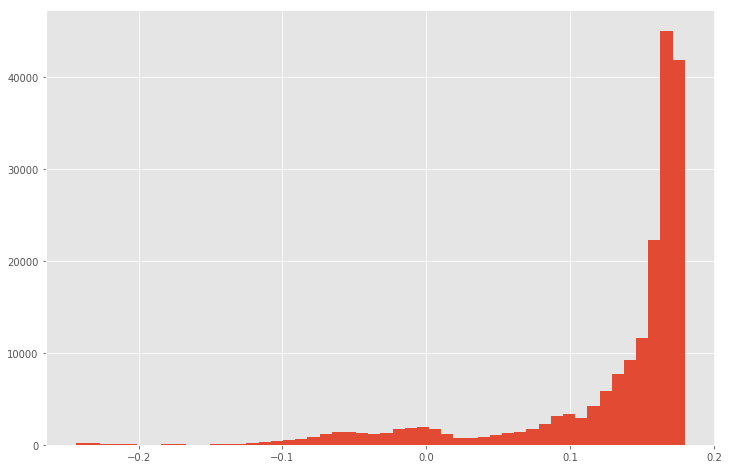

In [12]:
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);

So we see, that there is a clear cluster under -0.2. We consider average path lengths shorter than -0.2 as anomalies.

In [13]:
from sklearn.metrics import roc_auc_score

print("AUC: {:.1%}".format(roc_auc_score((-0.2 < scores), y_valid == list(encs["label"].classes_).index("normal."))))

AUC: 99.8%


**Source:**

    https://www.depends-on-the-definition.com/detecting-network-attacks-with-isolation-forests/
    https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf    